# **4. Prophet Model**

In [1]:
# https://www.kaggle.com/code/armandodelahoya/walmart-sales-forecasting-prophet-model
# https://www.kaggle.com/code/akritiupadhyayks/walmart-sales-forecasting-by-prophet-and-xgboost

## Imports

In [47]:
import pandas as pd
from datetime import datetime
from zipfile import ZipFile

#matplotlib configuration
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
# %matplotlib inline

# plt.style.use('fivethirtyeight')
# plt.rcParams['lines.linewidth'] = 1.5
# plt.rcParams['font.family'] = 'Trebuchet MS'

# matplotlib.rcParams['font.size'] = 15
# matplotlib.rcParams['figure.figsize'] = (8, 6)
# matplotlib.rcParams['figure.facecolor'] = '#00000000'
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV


#Metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

In [3]:
# Prophet
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
# plt.style.use('fivethirtyeight') # For plots

#plotly configuration
import plotly.offline as py

In [14]:
# Helper function for evalution metrics
def evaluation_metrics(y_test,y_pred):
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test,y_pred)
    r2score = r2_score(y_test,y_pred)
    
    print(f'Mean Squared Error = {mse}')
    print(f'Mean Absolute Error = {mae}')
    print(f'Root Mean Squared Error = {rmse}')
    print(f'r2 score = {r2score}')

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [5]:
df = pd.read_csv('data/data_eda.csv')

In [6]:
df.head()

,Date,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,Weekly_Sales,Type,Size
0,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,1,24924.50,A,151315
1,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2,50605.27,A,151315
2,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,3,13740.12,A,151315
3,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,4,39954.04,A,151315
4,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,5,32229.38,A,151315


In [7]:
df.rename(columns = {'Weekly_Sales': 'y', 'Date': 'ds'}, inplace = True)
df.head()

,ds,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,y,Type,Size
0,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,1,24924.50,A,151315
1,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2,50605.27,A,151315
2,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,3,13740.12,A,151315
3,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,4,39954.04,A,151315
4,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,5,32229.38,A,151315


In [8]:
df['ds'] = pd.to_datetime(df['ds'])

In [9]:
df.dtypes

ds              datetime64[ns]
Store                    int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                 bool
Dept                     int64
y                      float64
Type                    object
Size                     int64
dtype: object

In [10]:
merged_df = df[['ds','y','Temperature','Fuel_Price','CPI','Unemployment', 'Dept', 'Size', 'Store']]

In [11]:
merged_df.head()

,ds,y,Temperature,Fuel_Price,CPI,Unemployment,Dept,Size,Store
0,2010-02-05,24924.50,42.31,2.572,211.096358,8.106,1,151315,1
1,2010-02-05,50605.27,42.31,2.572,211.096358,8.106,2,151315,1
2,2010-02-05,13740.12,42.31,2.572,211.096358,8.106,3,151315,1
3,2010-02-05,39954.04,42.31,2.572,211.096358,8.106,4,151315,1
4,2010-02-05,32229.38,42.31,2.572,211.096358,8.106,5,151315,1


In [43]:
# X = merged_df.drop(columns='y')
# y = merged_df[['y']]

In [44]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False, random_state=123)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [12]:
from prophet import Prophet
m = Prophet(daily_seasonality=True)
m.add_regressor('Temperature')
m.add_regressor('Fuel_Price')
m.add_regressor('CPI')
m.add_regressor('Unemployment')
m.add_regressor('Dept')
m.add_regressor('Size')
# m.add_regressor('Type')
m.add_regressor('Store')
model_fit = m.fit(merged_df)

18:57:14 - cmdstanpy - INFO - Chain [1] start processing
18:57:46 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
forecast = model_fit.predict(merged_df)
# forecast[['ds','yhat','Temperature','Fuel_Price','CPI','Unemployment', 'Dept', 'Size', 'Store']].tail()
forecast[['ds','yhat']].tail()

,ds,yhat
421565,2012-10-26,24703.764076
421566,2012-10-26,24814.938680
421567,2012-10-26,25037.287889
421568,2012-10-26,12512.276192
421569,2012-10-26,17026.918921


In [19]:
forecast = model_fit.predict(merged_df)
forecast[['ds','yhat','Temperature','Fuel_Price','CPI','Unemployment', 'Dept', 'Size', 'Store']].tail()
# forecast[['ds','yhat']].tail()

,ds,yhat,Temperature,Fuel_Price,CPI,Unemployment,Dept,Size,Store
421565,2012-10-26,24703.764076,-1517.686296,324.122666,1172.574734,948.792741,526.932339,7376.745802,733.986418
421566,2012-10-26,24814.938680,-1517.686296,324.122666,1172.574734,948.792741,638.106943,7376.745802,733.986418
421567,2012-10-26,25037.287889,-1517.686296,324.122666,1172.574734,948.792741,860.456152,7376.745802,733.986418
421568,2012-10-26,12512.276192,-2115.735307,267.356245,-821.136127,715.983924,-4475.924853,5303.189462,-1499.752824
421569,2012-10-26,17026.918921,-143.446015,428.605789,-618.600102,-286.635231,5974.487949,-1646.930709,-1818.858430


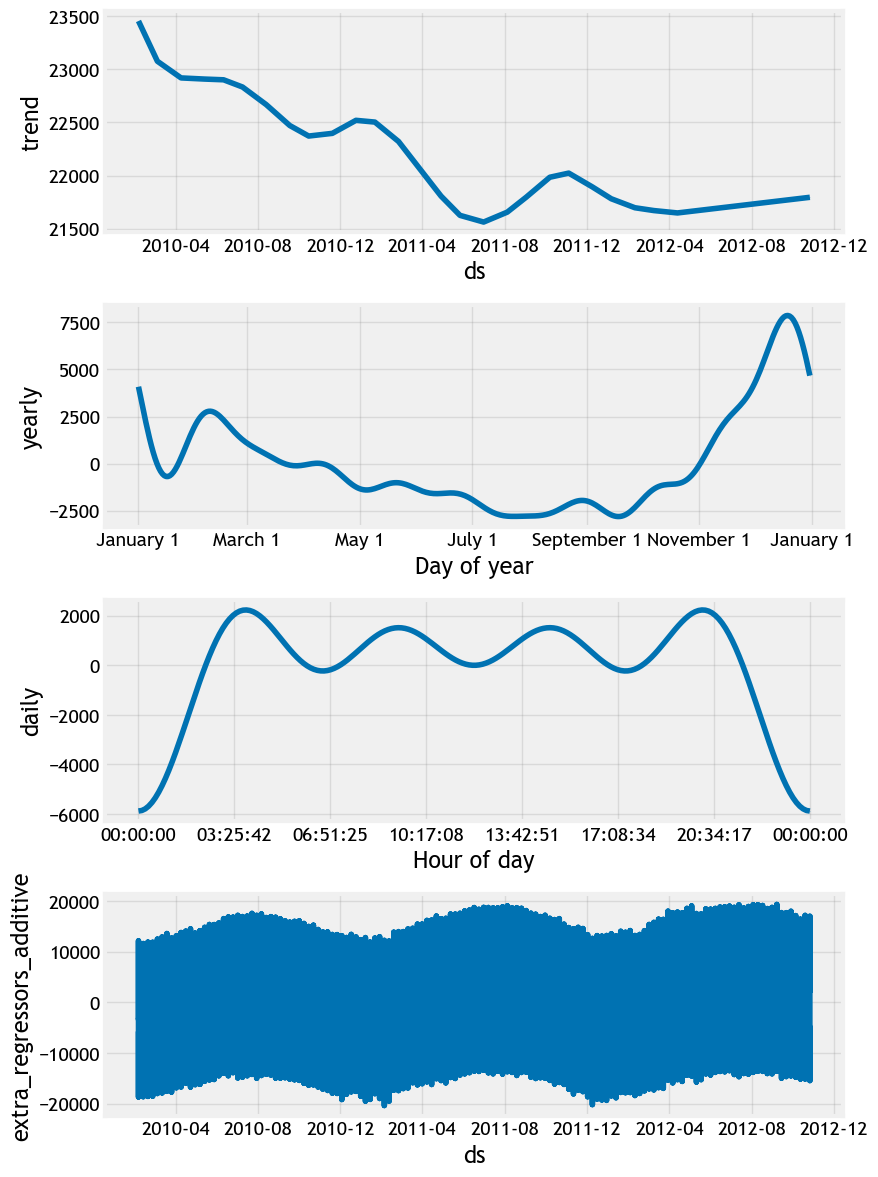

In [20]:
model_fit.plot_components(forecast);

In [21]:
predictions = forecast[['ds','yhat']]
predictions = predictions.rename(columns = {'ds':'Date','yhat':'Weekly_Sales'})
predictions.head()

,Date,Weekly_Sales
0,2010-02-05,14428.198387
1,2010-02-05,7875.610257
2,2010-02-05,7986.784861
3,2010-02-05,8097.959465
4,2010-02-05,8209.134070


In [ ]:
# Comparison = X_test.copy("deep")
# Comparison['Actual Sales ($M)'] = y_test['Weekly_Sales']
# Comparison['Predicted Sales ($M)'] = xgb_preds
# Comparison.head()

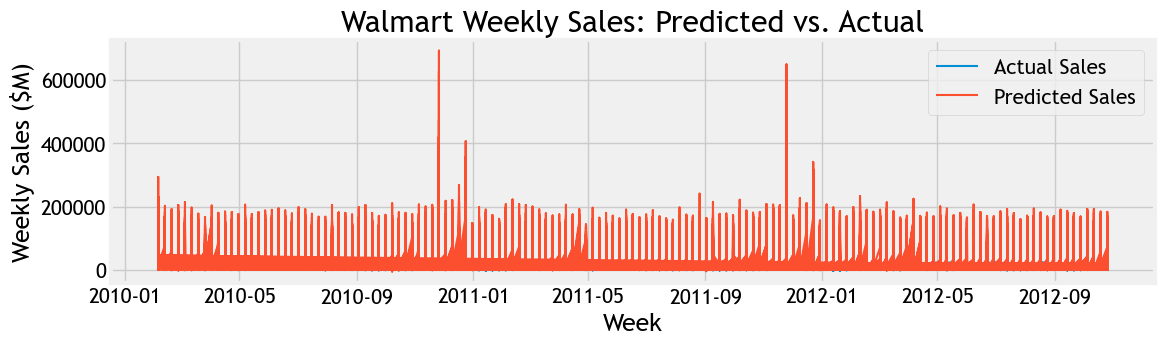

In [59]:
# plt.subplots(figsize = (15,8))
# sns.lineplot(forecast,x = 'ds',y='y',legend='full')
# sns.lineplot(predictions,x = 'Date',y = 'Weekly_Sales',legend='full')
# plt.legend(labels = ['Actual','','Prediction'])
# plt.ticklabel_format(useOffset=False,style='plain',axis='y')
# plt.show()

plt.figure(figsize = (12,3))
# sns.lineplot(Comparison1, x = 'Date', y = 'Actual Sales ($M)')
# sns.lineplot(Comparison1, x = 'Date', y = 'Predicted Sales ($M)')
plt.plot(predictions['Date'], predictions['Weekly_Sales'])
plt.plot(merged_df['ds'], merged_df['y'])
# plt.plot(Comparison1, x = 'Date', y = 'Predicted Sales ($M)')
# plt.ylim(40, 55)
# plt.ticklabel_format(useOffset=False,style='plain',axis='y')
plt.xlabel('Week')
plt.ylabel('Weekly Sales ($M)')
plt.title('Walmart Weekly Sales: Predicted vs. Actual')
plt.legend(['Actual Sales','Predicted Sales'])
plt.show()

In [64]:
predictions['Date'] = pd.to_datetime(predictions['Date'])
predictions['Year'] = predictions['Date'].dt.year
predictions['Month'] = predictions['Date'].dt.month
predictions['MonthName'] = predictions['Date'].dt.month_name()
# predictions['Week'] = predictions['Date'].dt.week
predictions['Week'] = pd.to_datetime(predictions['Date']).dt.isocalendar().week

In [65]:
predictions.head()

,Date,Weekly_Sales,Year,Month,MonthName,Week
0,2010-02-05,14428.198387,2010,2,February,5
1,2010-02-05,7875.610257,2010,2,February,5
2,2010-02-05,7986.784861,2010,2,February,5
3,2010-02-05,8097.959465,2010,2,February,5
4,2010-02-05,8209.134070,2010,2,February,5


In [85]:
x_time  = predictions.drop(columns=['Date', 'Weekly_Sales', 'MonthName'])
y_time = predictions[['Weekly_Sales']]

In [86]:
x_time_train,x_time_test,y_time_train,y_time_test = train_test_split(x_time,y_time,test_size=0.2,random_state=20)

In [87]:
xgb_time_model = XGBRegressor()
xgb_time_model.fit(x_time_train, y_time_train)
xgb_time_pred = xgb_time_model.predict(x_time_test)

In [88]:
x_time_train.shape,y_time_train.shape,x_time_test.shape,y_time_test.shape,xgb_time_pred.shape

((337256, 3), (337256, 1), (84314, 3), (84314, 1), (84314,))

In [99]:
Comparison = x_time_test.copy("deep")
Comparison['Actual Sales ($M)'] = y_time_test/1000000
Comparison['Predicted Sales ($M)'] = xgb_time_pred/1000000
Comparison

,Year,Month,Week,Actual Sales ($M),Predicted Sales ($M)
131992,2010,12,50,0.017959,0.021632
72454,2010,7,29,0.013251,0.015968
366604,2012,6,25,0.013651,0.016511
358969,2012,6,22,0.021321,0.016200
290838,2011,12,51,0.029549,0.021220
...,...,...,...,...,...
227167,2011,7,30,0.017210,0.015650
176276,2011,4,13,0.011233,0.014755
164686,2011,3,9,0.019803,0.015492
371760,2012,7,27,0.015956,0.016204


In [170]:
Comparison1 = Comparison.groupby(['Year', 'Week'])[['Actual Sales ($M)', 'Predicted Sales ($M)']].sum()

In [171]:
Comparison1.columns

Index(['Actual Sales ($M)', 'Predicted Sales ($M)'], dtype='object')

In [172]:
Comparison1.reset_index(inplace=True)

In [173]:
Comparison1

,Year,Week,Actual Sales ($M),Predicted Sales ($M)
0,2010,5,9.838555,9.694373
1,2010,6,9.968792,9.910077
2,2010,7,9.060417,9.339530
3,2010,8,9.044885,8.913022
4,2010,9,9.062330,9.246653
...,...,...,...,...
138,2012,39,9.047666,9.147146
139,2012,40,9.571564,9.400782
140,2012,41,8.870428,9.094156
141,2012,42,8.887266,8.932677


In [174]:
Comparison1['YearWeek'] = Comparison1['Year'].astype(str) + '-' + Comparison1['Week'].astype(str)
# Comparison1['YearWeek'] = pd.concat([Comparison1['Year'], Comparison1['Week']], axis=1).apply(lambda row: ' '.join(row), axis=1)

In [175]:
Comparison1

,Year,Week,Actual Sales ($M),Predicted Sales ($M),YearWeek
0,2010,5,9.838555,9.694373,2010-5
1,2010,6,9.968792,9.910077,2010-6
2,2010,7,9.060417,9.339530,2010-7
3,2010,8,9.044885,8.913022,2010-8
4,2010,9,9.062330,9.246653,2010-9
...,...,...,...,...,...
138,2012,39,9.047666,9.147146,2012-39
139,2012,40,9.571564,9.400782,2012-40
140,2012,41,8.870428,9.094156,2012-41
141,2012,42,8.887266,8.932677,2012-42


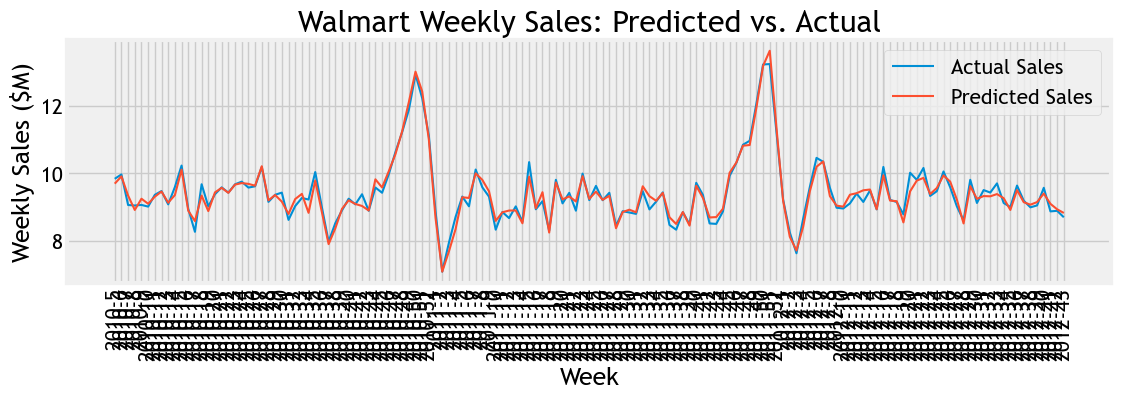

In [176]:
plt.figure(figsize = (12,3))
# sns.lineplot(Comparison1, x = 'Date', y = 'Actual Sales ($M)')
# sns.lineplot(Comparison1, x = 'Date', y = 'Predicted Sales ($M)')
plt.plot(Comparison1['YearWeek'], Comparison1['Actual Sales ($M)'])
plt.plot(Comparison1['YearWeek'], Comparison1['Predicted Sales ($M)'])
# plt.plot(Comparison1['Week'], Comparison1['Actual Sales ($M)'])
# plt.plot(Comparison1['Week'], Comparison1['Predicted Sales ($M)'])
# plt.plot(Comparison1, x = 'Date', y = 'Predicted Sales ($M)')
# plt.ylim(40, 55)
# plt.ticklabel_format(useOffset=False,style='plain',axis='y')
plt.xlabel('Week')
plt.ylabel('Weekly Sales ($M)')
plt.title('Walmart Weekly Sales: Predicted vs. Actual')
plt.xticks(rotation=90)

plt.legend(['Actual Sales','Predicted Sales'])
plt.show()

In [177]:
evaluation_metrics(Comparison1['Actual Sales ($M)'], Comparison1['Predicted Sales ($M)'])

Mean Squared Error = 0.029143009759094167
Mean Absolute Error = 0.13203529056241953
Root Mean Squared Error = 0.17071323838265787
r2 score = 0.9669044790399987


In [179]:
Comparison1['Error'] = (Comparison1['Actual Sales ($M)'] - Comparison1['Predicted Sales ($M)'])/Comparison1['Actual Sales ($M)']

In [182]:
Comparison1['Error'].sort_values()

80    -0.044003
12    -0.038639
112   -0.037840
57    -0.031432
69    -0.030881
         ...   
37     0.037142
51     0.041591
62     0.041840
29     0.042872
119    0.055193
Name: Error, Length: 143, dtype: float64

### Test Data

In [155]:
data_test = pd.read_csv('data/data_test.csv')

In [156]:
# Split date up into year, month, week, day for more
data_test['Day'] = pd.to_datetime(data_test['Date']).dt.day
data_test['Year'] = pd.to_datetime(data_test['Date']).dt.year
data_test['Month'] = pd.to_datetime(data_test['Date']).dt.month
data_test['Week'] = pd.to_datetime(data_test['Date']).dt.isocalendar().week

In [157]:
data_test.set_index('Date', inplace=True)

In [158]:
data_test.head()

,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,...,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Day,Year,Month,Week
Date,,,,,,,,,,,,,,,,,,,,,
2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,...,False,False,False,False,False,False,2,2012,11,44
2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,...,False,False,False,False,False,False,2,2012,11,44
2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,...,False,False,False,False,False,False,2,2012,11,44
2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,...,False,False,False,False,False,False,2,2012,11,44
2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,...,False,False,False,False,False,False,2,2012,11,44


In [159]:
data_test.shape

(115064, 141)

In [160]:
data_test.isna().sum().sort_values(ascending=False)

CPI             38162
Unemployment    38162
Temperature         0
Dept_43             0
Dept_37             0
                ...  
Store_31            0
Store_30            0
Store_29            0
Store_28            0
Week                0
Length: 141, dtype: int64

In [161]:
data_test = data_test.fillna(data_test.mean())

In [162]:
data_test.isna().sum().sort_values(ascending=False)

Temperature    0
Dept_43        0
Dept_37        0
Dept_38        0
Dept_39        0
              ..
Store_30       0
Store_29       0
Store_28       0
Store_27       0
Week           0
Length: 141, dtype: int64

In [165]:
data_test.reset_index(inplace=True)

C:\Users\johng\AppData\Local\Temp\ipykernel_27988\3504863054.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [166]:
data_test.rename(columns = {'Weekly_Sales': 'y', 'Date': 'ds'}, inplace = True)

In [167]:
data_test

,ds,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,...,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Day,Year,Month,Week
0,2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573000,...,False,False,False,False,False,False,2,2012,11,44
1,2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573000,...,False,False,False,False,False,False,2,2012,11,44
2,2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573000,...,False,False,False,False,False,False,2,2012,11,44
3,2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573000,...,False,False,False,False,False,False,2,2012,11,44
4,2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573000,...,False,False,False,False,False,False,2,2012,11,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,176.961347,6.868733,...,False,False,False,False,False,False,26,2013,7,30
115060,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,176.961347,6.868733,...,True,False,False,False,False,False,26,2013,7,30
115061,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,176.961347,6.868733,...,False,True,False,False,False,False,26,2013,7,30
115062,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,176.961347,6.868733,...,False,False,False,True,False,False,26,2013,7,30


In [168]:
test_preds = model_fit.predict(data_test)

ValueError: Regressor 'Dept' missing from dataframe

## Submission

In [ ]:
submission1 = pd.read_csv('data/sampleSubmission.csv')

In [ ]:
submission1['Weekly_Sales'] = test_preds

In [ ]:
submission1.set_index('Id', inplace=True)

In [ ]:
submission1.to_csv('data/submission2_prophet.csv')